In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numba import njit , prange
from matplotlib.colors import TwoSlopeNorm
import progressbar
import hints
from itertools import permutations
import matplotlib.gridspec as gridspec
import matplotlib
from matplotlib.ticker import AutoMinorLocator
from scipy.io import loadmat
import glob
import imageio.v2 as imageio
import scipy
from statsmodels.tsa.stattools import adfuller


def ReadEU7():
    folder="Synchronised measurements/"
    FIN_AU = pd.read_csv(folder+'finland_AU.csv.zip', index_col=0)
    FIN_TTY = pd.read_csv(folder+'finland_TTY.csv.zip', index_col=0)
    NOR_NTUN = pd.read_csv(folder+'norway_NTNU.csv.zip', index_col=0)
    SWE_CTH = pd.read_csv(folder+'sweden_CTH.csv.zip', index_col=0)
    SWE_KTH = pd.read_csv(folder+'sweden_KTH.csv.zip', index_col=0)
    SWE_LTH = pd.read_csv(folder+'sweden_LTH.csv.zip', index_col=0)
    SWE_LTU = pd.read_csv(folder+'sweden_LTU.csv.zip', index_col=0)

    FIN_AU['date']=FIN_AU.index
    FIN_TTY['date']=FIN_TTY.index
    NOR_NTUN['date']=NOR_NTUN.index
    SWE_CTH['date']=SWE_CTH.index
    SWE_KTH['date']=SWE_KTH.index
    SWE_LTH['date']=SWE_LTH.index
    SWE_LTU['date']=SWE_LTU.index


    FIN_AU.rename(columns = {'Frequency':'FIN_AU'}, inplace = True)
    FIN_TTY.rename(columns = {'Frequency':'FIN_TTY'}, inplace = True)
    NOR_NTUN.rename(columns = {'Frequency':'NOR_NTUN'}, inplace = True)
    SWE_CTH.rename(columns = {'Frequency':'SWE_CTH'}, inplace = True)
    SWE_KTH.rename(columns = {'Frequency':'SWE_KTH'}, inplace = True)
    SWE_LTH.rename(columns = {'Frequency':'SWE_LTH'}, inplace = True)
    SWE_LTU.rename(columns = {'Frequency':'SWE_LTU'}, inplace = True)

    FIN_AU=FIN_AU[['date',"FIN_AU"]]
    FIN_TTY=FIN_TTY[['date',"FIN_TTY"]]
    NOR_NTUN=NOR_NTUN[['date',"NOR_NTUN"]]
    SWE_CTH=SWE_CTH[['date',"SWE_CTH"]]
    SWE_KTH=SWE_KTH[['date',"SWE_KTH"]]
    SWE_LTH=SWE_LTH[['date',"SWE_LTH"]]
    SWE_LTU=SWE_LTU[['date',"SWE_LTU"]]

    FIN_AU.reset_index(drop=True, inplace=True)
    FIN_TTY.reset_index(drop=True, inplace=True)
    NOR_NTUN.reset_index(drop=True, inplace=True)
    SWE_CTH.reset_index(drop=True, inplace=True)
    SWE_KTH.reset_index(drop=True, inplace=True)
    SWE_LTH.reset_index(drop=True, inplace=True)
    SWE_LTU.reset_index(drop=True, inplace=True)

    EU7 = pd.merge(FIN_AU, FIN_TTY, on='date', how='inner')
    EU7 = pd.merge(EU7, NOR_NTUN, on='date', how='inner')
    EU7 = pd.merge(EU7, SWE_CTH, on='date', how='inner')
    EU7 = pd.merge(EU7, SWE_KTH, on='date', how='inner')
    EU7 = pd.merge(EU7, SWE_LTH, on='date', how='inner')
    EU7 = pd.merge(EU7, SWE_LTU, on='date', how='inner')

    dates = EU7['date']

    EU7.drop('date',inplace=True,axis=1)
    EU7=EU7.to_numpy()
    EU7=np.swapaxes(EU7,0,1)

    cols_with_nan = np.isnan(EU7).any(axis=0)
    EU7 = EU7[:, ~cols_with_nan]

    np.save(folder+"EU7.npy",EU7)
    dates.to_csv(folder+"EU7_dates.csv", index=False)

def LoadEU7():
    folder="Synchronised measurements/"
    EU7=np.load(folder+"EU7.npy")
    dates = pd.read_csv(folder+"EU7_dates.csv")
    dates['date'] = pd.to_datetime(dates['date']) 
    npdates=dates['date'].dt.strftime('%Y-%m-%d %H:%M:%S').to_numpy()     # .%f    
    return EU7, dates, npdates 

@njit(parallel=True)
def localnorm( nl, data):
    newdata=np.zeros((data.shape[0],int(data.shape[1]-nl)))
    for i in prange(data.shape[0]):
        for j in range(nl, data.shape[1]):  
            newdata[i,j-nl] = (data[i,j] - np.mean(data[i,j-nl:j])) / np.std(data[i,j-nl:j])
    return newdata


def KMC_ABC(x,dt,N,M,mode,method):
    
    # if method=='abolfazl':
    #     x, y = caly(x, N)
    #     Dcoeffs, ind, col = calD1coef(x, y, dt, N, M, mode)
    # elif method=='hints':
    #     calulator = hints.kmcc(ts_array=np.swapaxes(x,0,1), dt=dt, interaction_order=M, estimation_mode='drift')
    #     Dcoeffs = calulator.get_coefficients()  
    # elif method=='hints2' or method=='amin':   
    #     Dcoeffs = kmc(np.swapaxes(x,0,1), dt=dt, order=[1,2,3], mode='drift', **{'window_order':5, 'solver':'both', 'threshold':1e-15})   # 0
    # else:
    #     raise ValueError("Method options are: 'abolfazl', 'hints', 'hints2' ")

    calulator = hints.kmcc(ts_array=np.swapaxes(x,0,1), dt=dt, interaction_order=M, estimation_mode='drift')
    Dcoeffs = calulator.get_coefficients()  
    Dcoeffs = np.swapaxes(Dcoeffs.to_numpy(), 0, 1)

    Constant = np.zeros(N)
    A = np.zeros((N, N))        
    B = np.zeros((N, N, N))    
    C = np.zeros((N, N, N, N))  

    
    num_first_order = N
    num_second_order = int(N * (N + 1) / 2)
    num_third_order = int(N * (N + 1) * (N + 2) / 6)

    
    if 0 in M:  
        Constant[:] = Dcoeffs[:, 0]
        A[:, :] = Dcoeffs[:, 1:N+1]  
    else:
        A[:, :] = Dcoeffs[:, :N]     
    
    
    if 2 in M:  
        if 0 in M:
            counter = num_first_order + 1
        else:    
            counter = num_first_order
        for i in range(N):
            for j in range(i, N):
                for idx in set(permutations((i, j))): B[:, idx[0], idx[1]] = Dcoeffs[:, counter]
                counter += 1

    if 3 in M:  
        if 0 in M:
            counter = num_first_order + num_second_order + 1
        else:
            counter = num_first_order + num_second_order
        for i in range(N):
            for j in range(i, N):
                for k in range(j, N):
                    for idx in set(permutations((i, j, k))): C[:, idx[0], idx[1], idx[2]] = Dcoeffs[:, counter]
                    counter += 1

    return Constant, A, B, C, Dcoeffs

def KMC_ABC_overtime(data,win,ol,N,M,mode,dt,tstart,zmean,uvar,method):
    dx=win*(100-ol)/100
    n_win=int((data.shape[1]-win)/dx+1)
    alleval=[]
    allevec=[]
    allcons=np.zeros((n_win,N))
    alla=np.zeros((n_win,N,N))
    allb=np.zeros((n_win,N,N,N))
    allc=np.zeros((n_win,N,N,N,N))
    alldcoefllist=[]
    t=int(win/2+tstart)
    tlist=[]
    ii=0
    tarray=np.arange(int(win / 2 + tstart), int(data.shape[1] - win / 2), dx)

    # bar = progressbar.ProgressBar(maxval=len(tarray),  redirect_stdout=True,  redirect_stderr=True, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    # bar.start()


    for t in tarray:
        tlist.append(t)
        start=int(t-win/2)
        end=int(t+win/2)
        x=np.zeros((N,win))
        x[:,:]=data[:,start:end]

        for i in range(N):
            if zmean==True:
                x[i,:]=x[i,:]-np.mean(x[i,:])
            if uvar==True:
                x[i,:]=x[i,:]/np.std(x[i,:])

        cons, A, B, C, Dcoeffs=KMC_ABC(x,dt,N,M,mode,method)
        allcons[ii,:]=cons[:]
        alla[ii,:,:]=A[:,:]
        allb[ii,:,:,:]=B[:,:,:]
        allc[ii,:,:,:,:]=C[:,:,:,:]
        alldcoefllist.append(Dcoeffs)
        
        w, v = np.linalg.eig(A)
        alleval.append(w)
        allevec.append(v)
        ii+=1
    #     bar.update(ii)
    # bar.finish()

    alldcoefllist=np.array(alldcoefllist)
    alleval=np.array(alleval)
    allevec=np.array(allevec)


    return tlist, allcons, alla, allb, allc, alldcoefllist, alleval, allevec

# Load the data

In [3]:
ReadEU7()
EU7, dates, npdates = LoadEU7()
nl=1000
EU72=localnorm(nl, EU7)

# Run the code

In [4]:
dt=0.02
N=7
M=[1,2,3]
mode='list'
win=540000
ol=95
tstart=0
zmean=True
uvar=True
method='hints'
tlist, allcons, alla, allb, allc, alldcoefllist, alleval, allevec=KMC_ABC_overtime(EU72,win,ol,N,M,mode,dt,tstart,zmean,uvar,method)

# Mathematica Data

In [ ]:
NumberOfStable_UnstableFixedPoints=np.loadtxt("res/NumberOfStable&UnstableFixedPoints.txt")    #  (220,2)
ChosenStableFixedPointValues=np.loadtxt("res/ChosenStableFixedPointValues.txt")                #  (220,7)
ChosenFixedPointRightMostEigenValueReal=np.loadtxt("res/ChosenFixedPointRightMostEigenValueReal.txt")   # (220)
ChosenFixedPointLeftMostEigenValueReal=np.loadtxt("res/ChosenFixedPointLeftMostEigenValueReal.txt")     # (220)

ChosenFixedPointAllEigenvalues = loadmat('res/ChosenFixedPointAllEigenvalues.mat')               # (220,7)
ChosenFixedPointAllEigenvalues=np.array(ChosenFixedPointAllEigenvalues["Expression1"])  

EffectiveAdjacency = loadmat('res/EffectiveAdjacency.mat')   
EffectiveAdjacency=np.array(EffectiveAdjacency["Expression1"])  

chosenFixedPointEigenvectors = loadmat('res/chosenFixedPointEigenvectors.mat')   
chosenFixedPointEigenvectors=np.array(chosenFixedPointEigenvectors["Expression1"])  

RightmostEigenvectorLargestIndexe = np.loadtxt("res/RightmostEigenvectorLargestIndexe.txt")
LeftmostEigenvectorLargestIndexe = np.loadtxt("res/LeftmostEigenvectorLargestIndexe.txt")


# Final Plot

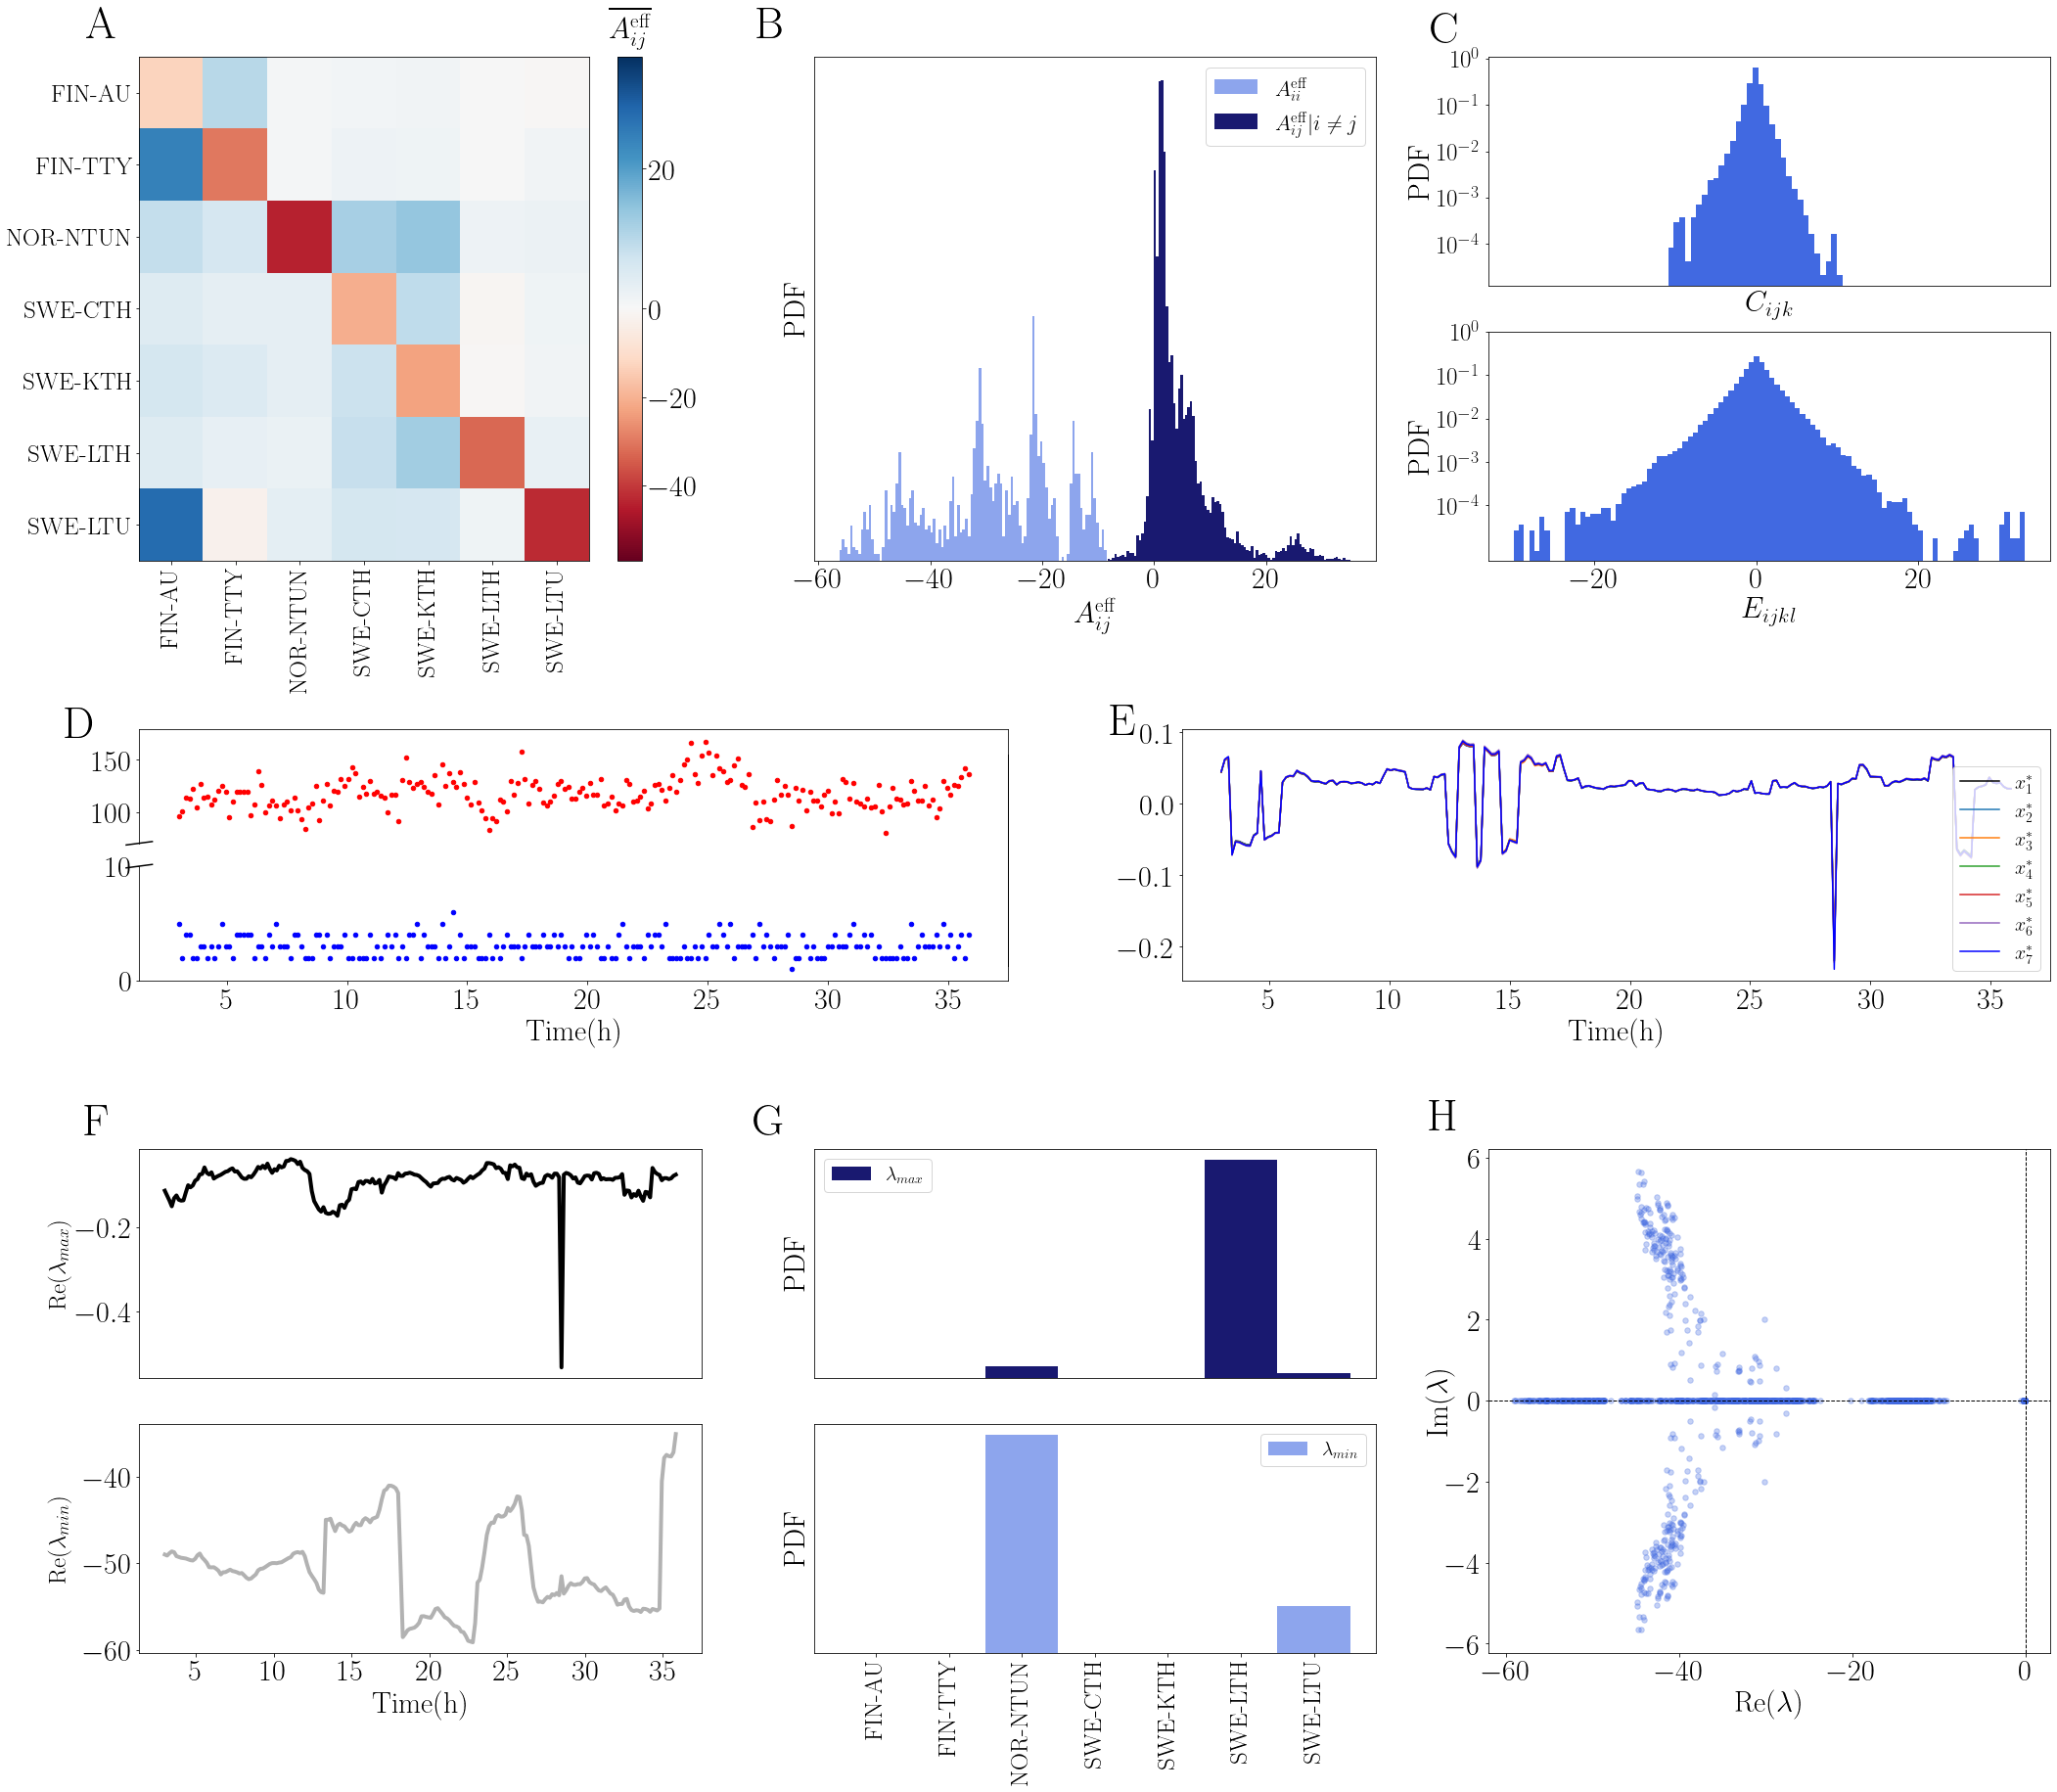

In [ ]:
plt.rc('text', usetex=True)
plt.rc('font', **{'family':'Computer Modern','size':20})


panel_label_pos=[-0.1,1.1]
panel_fontsize=46
xy_fontsize=30
legend_fontsize=20
start_time = dates['date'].iloc[0]
time_labels = [dates['date'].iloc[int(t + win/2)].strftime('%Y-%m-%d %H:%M:%S') for t in tlist]
n = 1 if len(tlist) < 11 else int(len(tlist) / 15) # Only show every nth label on x-axis
nth_time_labels=[time_labels[i] for i in np.arange(0, len(time_labels), step=n)]
time_elapsed = [(date - start_time).total_seconds() / 3600 for date in pd.to_datetime(time_labels) ]  
nth_time_gone=np.array([int(time_elapsed[i]) for i in np.arange(0, len(time_labels), step=n)])
last_interval = nth_time_gone[-1] - nth_time_gone[-2]
nth_time_gone=np.append(nth_time_gone, nth_time_gone[-1] + last_interval) 


fig = plt.figure(figsize=(35, 30))

main_gs = gridspec.GridSpec(3, 1, height_ratios=[1, 0.5, 1] , hspace=0.4, wspace=0.1)  # Adjust the height_ratios as needed
gs_top = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=main_gs[0], height_ratios=[1] , hspace=0.2, wspace=0.2)
gs_mid= gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=main_gs[1], height_ratios=[0.5],  hspace=0.1, wspace=0.2)
gs_bot = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=main_gs[2], height_ratios=[1],  hspace=0.1, wspace=0.2)



# Panel A
####################################################################################################################################
ax1 = fig.add_subplot(gs_top[0, 0])  
Amean=np.mean(EffectiveAdjacency, axis=0)
ticks=np.arange(len(EU7))
ticklist=["FIN-AU","FIN-TTY","NOR-NTUN","SWE-CTH","SWE-KTH","SWE-LTH","SWE-LTU"]
im = ax1.imshow(Amean, aspect='auto', cmap="RdBu", norm=TwoSlopeNorm(vmin=np.min(int(np.min(EffectiveAdjacency))-1), vcenter=0, vmax=np.max(int(np.max(EffectiveAdjacency))+1)))
cbar=fig.colorbar(im, ax=ax1,orientation="vertical")
cbar.ax.set_title(r'$\overline{A_{ij}^{\mathrm{eff}}}$', fontsize=xy_fontsize,pad=20)
cbar.ax.tick_params(labelsize=xy_fontsize)
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(ticklist, fontsize=xy_fontsize-5, rotation=90)
ax1.set_yticklabels(ticklist, fontsize=xy_fontsize-5)
ax1.text(panel_label_pos[0]+0.05, panel_label_pos[1], 'A', transform=ax1.transAxes, fontsize=panel_fontsize,  va='top', ha='right')  # fontweight='bold',




# Panel B
####################################################################################################################################
ax2 = fig.add_subplot(gs_top[0, 1])
diagonal_elements = []
off_diagonal_elements = []
for matrix in EffectiveAdjacency:
    diagonal_elements.extend(np.diag(matrix))
    off_diagonal_elements.extend(matrix[~np.eye(matrix.shape[0], dtype=bool)])  
ax2.hist(diagonal_elements, color='royalblue', density=True, bins=100, alpha=0.6, label=r'$A_{ii}^{\mathrm{eff}}$')
ax2.hist(off_diagonal_elements, color='midnightblue', density=True, bins=100, alpha=1, label=r'$A_{ij}^{\mathrm{eff}} | i \neq j$')
ax2.set_xlabel(r'$A_{ij}^{\mathrm{eff}}$', fontsize=xy_fontsize)   
ax2.set_ylabel('PDF', fontsize=xy_fontsize)  
ax2.set_yticks([])
ax2.legend(fontsize=22)
ax2.tick_params(axis='x', labelsize=xy_fontsize)
ax2.text(panel_label_pos[0]+0.05, panel_label_pos[1], 'B', transform=ax2.transAxes, fontsize=panel_fontsize,  va='top', ha='right')  # fontweight='bold',





# Panel C
####################################################################################################################################
ax3 = fig.add_subplot(gs_top[0, 2])  
gs = ax3.get_gridspec()  
ax3.remove()  
subgs = gs[0,2].subgridspec(2, 1, height_ratios=[1, 1])  
# Top 
diagonal_elements = []
off_diagonal_elements = []
i, j, k = np.indices(allb[0].shape)
off_diagonal_mask = (i != j) | (j != k) | (i != k)
for matrix in allb:
    diagonal_elements.extend( np.einsum('iii->i', matrix) )
    off_diagonal_elements.extend(matrix[ off_diagonal_mask ])   
ax_top = fig.add_subplot(subgs[0])
ax_top.hist(allb.flatten(), color='royalblue', density=True, bins=100, range=(np.min(allc), np.max(allc)), alpha=1)
ax_top.set_xlim(np.min(allc), np.max(allc))
ax_top.set_xlabel(r'$C_{ijk}$', fontsize=xy_fontsize, labelpad=5)
ax_top.set_ylabel('PDF', fontsize=xy_fontsize)
ax_top.set_yscale('log')
ax_top.set_yticks([0.0001, 0.001, 0.01, 0.1, 1])
ax_top.set_yticklabels([r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$"], fontsize=xy_fontsize-15)
ax_top.tick_params(axis='y', labelsize=xy_fontsize-5)
ax_top.set_xticks([]) 

# Bottom 
diagonal_elements = []
off_diagonal_elements = []
i, j, k, l = np.indices(allc[0].shape)
off_diagonal_mask = (i != j) | (i != k) | (i != l) | (j != k) | (j != l) | (k != l) 
for matrix in allc:
    diagonal_elements.extend( np.einsum('iiii->i', matrix) )
    off_diagonal_elements.extend(matrix[ off_diagonal_mask ])   
ax_bottom = fig.add_subplot(subgs[1])
ax_bottom.hist(allc.flatten(), color='royalblue', density=True, bins=100, alpha=1)
ax_bottom.set_xlabel(r'$E_{ijkl}$', fontsize=xy_fontsize)
ax_bottom.set_ylabel('PDF', fontsize=xy_fontsize)
ax_bottom.set_yscale('log')
ax_bottom.set_yticks([0.0001, 0.001, 0.01, 0.1, 1])
ax_bottom.set_yticklabels([r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$"], fontsize=xy_fontsize-15)
ax_bottom.tick_params(axis='y', labelsize=xy_fontsize-5)
ax_bottom.tick_params(axis='x', labelsize=xy_fontsize)

ax_top.text(panel_label_pos[0]+0.05, panel_label_pos[1]+0.1, 'C', transform=ax_top.transAxes, fontsize=panel_fontsize, va='top', ha='right')  



####################################################################################################################################
####################################################################################################################################
####################################################################################################################################





ax7 = fig.add_subplot(gs_mid[0, 0])  
gs = ax7.get_gridspec()  
ax7.remove()  
subgs = gs[0, 0].subgridspec(2, 1, height_ratios=[1, 1]) 
ax1 = fig.add_subplot(subgs[0])
ax2 = fig.add_subplot(subgs[1])
x=(np.array(tlist)+270000)*0.02/3600
ax1.scatter(x, NumberOfStable_UnstableFixedPoints[:,1], color='red', s=20, alpha=1)
ax2.scatter(x, NumberOfStable_UnstableFixedPoints[:,0], color='blue', s=20)
ax1.tick_params(axis='y', labelsize=xy_fontsize)
ax1.set_ylim(70, 180)  
ax2.set_ylim(0, 10)
ax1.xaxis.set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(True)
ax2.spines['right'].set_visible(True)
d = 0.015  
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs) 
kwargs.update(transform=ax2.transAxes)  
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs) 
fig.line = fig.add_artist(plt.Line2D((0.4773, 0.4773), (0.45, 0.55), color="black", transform=fig.transFigure, linewidth=1))
ax2.set_xlabel('Time(h)', fontsize=xy_fontsize, labelpad=5)
ax2.tick_params(axis='x', labelsize=xy_fontsize)
ax2.tick_params(axis='y', labelsize=xy_fontsize)
ax1.text(panel_label_pos[0]+0.05, panel_label_pos[1]+0.1, 'D', transform=ax1.transAxes, fontsize=panel_fontsize, va='top', ha='right')  







ax8 = fig.add_subplot(gs_mid[0, 1])  
x=(np.array(tlist)+270000)*0.02/3600
ax8.plot(x, ChosenStableFixedPointValues[:,0], label=rf"$x_{1}^*$", color='black')
ax8.plot(x, ChosenStableFixedPointValues[:,1], label=rf"$x_{2}^*$")
ax8.plot(x, ChosenStableFixedPointValues[:,2], label=rf"$x_{3}^*$")
ax8.plot(x, ChosenStableFixedPointValues[:,3], label=rf"$x_{4}^*$")
ax8.plot(x, ChosenStableFixedPointValues[:,4], label=rf"$x_{5}^*$")
ax8.plot(x, ChosenStableFixedPointValues[:,5], label=rf"$x_{6}^*$")
ax8.plot(x, ChosenStableFixedPointValues[:,6], label=rf"$x_{7}^*$", color='blue')
ax8.legend(loc="lower right", fontsize=20)
ax8.set_xlabel('Time(h)', fontsize=xy_fontsize, labelpad=5)
ax8.tick_params(axis='x', labelsize=xy_fontsize)
ax8.tick_params(axis='y', labelsize=xy_fontsize)
ax8.text(panel_label_pos[0]+0.05, panel_label_pos[1], 'E', transform=ax8.transAxes, fontsize=panel_fontsize,  va='top', ha='right')  # fontweight='bold',






####################################################################################################################################
####################################################################################################################################
####################################################################################################################################





ax4 = fig.add_subplot(gs_bot[0, 0])  
gs = ax4.get_gridspec()  
ax4.remove()  
subgs = gs[0, 0].subgridspec(2, 1, height_ratios=[1, 1])  

x=(np.array(tlist)+270000)*0.02/3600
# Top 
ax_top = fig.add_subplot(subgs[0])
ax_top.plot(x, ChosenFixedPointRightMostEigenValueReal, color='k', alpha=1, linewidth=4) 
ax_top.set_xticks([]) 
ax_top.set_ylabel(r'Re$(\lambda_{max})$', fontsize=25)
ax_top.tick_params(axis='y', labelsize=xy_fontsize)

# bottom subplot
ax_bottom = fig.add_subplot(subgs[1])
ax_bottom.plot(x, ChosenFixedPointLeftMostEigenValueReal, color='k', alpha=0.3, linewidth=4) 
ax_bottom.set_xticks([5,10,15,20,25,30,35])
ax_bottom.set_xlabel('Time(h)', fontsize=xy_fontsize, labelpad=5)
ax_bottom.set_ylabel(r'Re$(\lambda_{min})$', fontsize=25)
ax_bottom.tick_params(axis='x', labelsize=xy_fontsize)
ax_bottom.tick_params(axis='y', labelsize=xy_fontsize)

fig.align_ylabels([ax_top, ax_bottom])
ax_top.text(panel_label_pos[0]+0.05, panel_label_pos[1]+0.1, 'F', transform=ax_top.transAxes, fontsize=panel_fontsize, va='top', ha='right')  # fontweight='bold',

####################################################################################################################################
####################################################################################################################################
####################################################################################################################################




ax5 = fig.add_subplot(gs_bot[0, 1]) 
gs = ax5.get_gridspec()  
ax5.remove()  
subgs = gs[0, 1].subgridspec(2, 1, height_ratios=[1, 1]) # , hspace=0.1
largest_dimensions = []
for i in range(ChosenFixedPointAllEigenvalues.shape[0]):
    max_index = np.argmax(np.real(ChosenFixedPointAllEigenvalues[i]))  
    eigenfunction = chosenFixedPointEigenvectors[i][ max_index , : ]
    largest_dim = np.argmax(np.abs(eigenfunction))
    largest_dimensions.append(largest_dim)
smallest_dimensions = []
for i in range(ChosenFixedPointAllEigenvalues.shape[0]):
    min_index = np.argmin(np.real(ChosenFixedPointAllEigenvalues[i]))  
    eigenfunction = chosenFixedPointEigenvectors[i][min_index , :]
    smallest_dim = np.argmax(np.abs(eigenfunction))
    smallest_dimensions.append(smallest_dim)

bin_edges = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
tick_positions = [0, 1, 2, 3, 4, 5, 6]  
tick_labels = ["FIN-AU","FIN-TTY","NOR-NTUN","SWE-CTH","SWE-KTH","SWE-LTH","SWE-LTU"]
# Top 
ax_top = fig.add_subplot(subgs[0])
ax_top.hist(largest_dimensions, color='midnightblue', density=True, bins=bin_edges, alpha=1, label=r'$\lambda_{max}$')
ax_top.set_xticks(tick_positions)
ax_top.set_xticklabels(tick_labels)
ax_top.set_ylabel('PDF', fontsize=xy_fontsize)
ax_top.legend(fontsize=20)
ax_top.set_yticks([])
ax_top.set_xticks([])  
# Bottom 
ax_bottom = fig.add_subplot(subgs[1])
ax_bottom.hist(smallest_dimensions, color='royalblue', density=True, bins=bin_edges, alpha=0.6, label=r'$\lambda_{min}$')
ax_bottom.set_xticks(tick_positions)
ax_bottom.set_xticklabels(tick_labels, rotation=90)
ax_bottom.set_ylabel('PDF', fontsize=xy_fontsize)
ax_bottom.legend(fontsize=20)
ax_bottom.set_yticks([])
ax_bottom.tick_params(axis='x', labelsize=xy_fontsize-5)
ax_top.text(panel_label_pos[0]+0.05, panel_label_pos[1]+0.1, 'G', transform=ax_top.transAxes, fontsize=panel_fontsize, va='top', ha='right')  # fontweight='bold',



####################################################################################################################################
####################################################################################################################################
####################################################################################################################################




ax6 = fig.add_subplot(gs_bot[0, 2])  
real_parts = []
imaginary_parts = []
for i in range(ChosenFixedPointAllEigenvalues.shape[0]):
    real_parts.extend(np.real(ChosenFixedPointAllEigenvalues[i]))  
    imaginary_parts.extend(np.imag(ChosenFixedPointAllEigenvalues[i]))  
ax6.scatter(real_parts, imaginary_parts, c='royalblue', alpha=0.3, s=30)
ax6.axhline(0, color='k', linestyle='--', lw=1)  
ax6.axvline(0, color='k', linestyle='--', lw=1)  
ax6.set_xlabel(r'Re$(\lambda)$', fontsize=xy_fontsize)
ax6.set_ylabel(r'Im$(\lambda)$', fontsize=xy_fontsize, labelpad=-10)
ax6.tick_params(axis='x', labelsize=xy_fontsize)
ax6.tick_params(axis='y', labelsize=xy_fontsize)
ax6.text(panel_label_pos[0]+0.05, panel_label_pos[1], 'H', transform=ax6.transAxes, fontsize=panel_fontsize,  va='top', ha='right')  # fontweight='bold',






#plt.tight_layout()
plt.savefig('res/Power Grid Fig - Final - Final - Final (for real this time).jpeg', dpi=300, bbox_inches='tight')
# plt.savefig('res/Power Grid Fig - Final.pdf' , dpi=300, bbox_inches='tight')
plt.show()


# AVG C,E

In [24]:
N=7
dx=win*(100-ol)/100
AVG_C=np.mean(allb, axis=0)
AVG_E=np.mean(allc, axis=0)
Error_C=np.std(allb, axis=0)/np.sqrt(len(np.arange(int(win / 2 + tstart), int(EU7.shape[1] - win / 2), dx)))
Error_E=np.std(allc, axis=0)/np.sqrt(len(np.arange(int(win / 2 + tstart), int(EU7.shape[1] - win / 2), dx)))


C_index_list=[]
for j in range(N):
    for k in range(j,N):
        C_index_list.append(f"{j+1}-{k+1}")
E_index_list=[]
for j in range(N):
    for k in range(j,N):
        for l in range(k,N):
            E_index_list.append(f"{j+1}-{k+1}-{l+1}")

C_i=np.zeros((N,int(N*(N+1)/2)))
C_i_error=np.zeros((N,int(N*(N+1)/2)))
E_i=np.zeros((N,int(N*(N+1)*(N+2)/6)))
E_i_error=np.zeros((N,int(N*(N+1)*(N+2)/6)))


for i in range(N):
    counter=0
    for j in range(N):
        for k in range(j,N):
            C_i[i,int(counter)]=AVG_C[i,j,k]
            C_i_error[i,int(counter)]=Error_C[i,j,k]
            counter+=1


for i in range(N):
    counter=0
    for j in range(N):
        for k in range(j,N):
            for l in range(k,N):
                E_i[i,int(counter)]=AVG_E[i,j,k,l]
                E_i_error[i,int(counter)]=Error_E[i,j,k,l]
                counter+=1



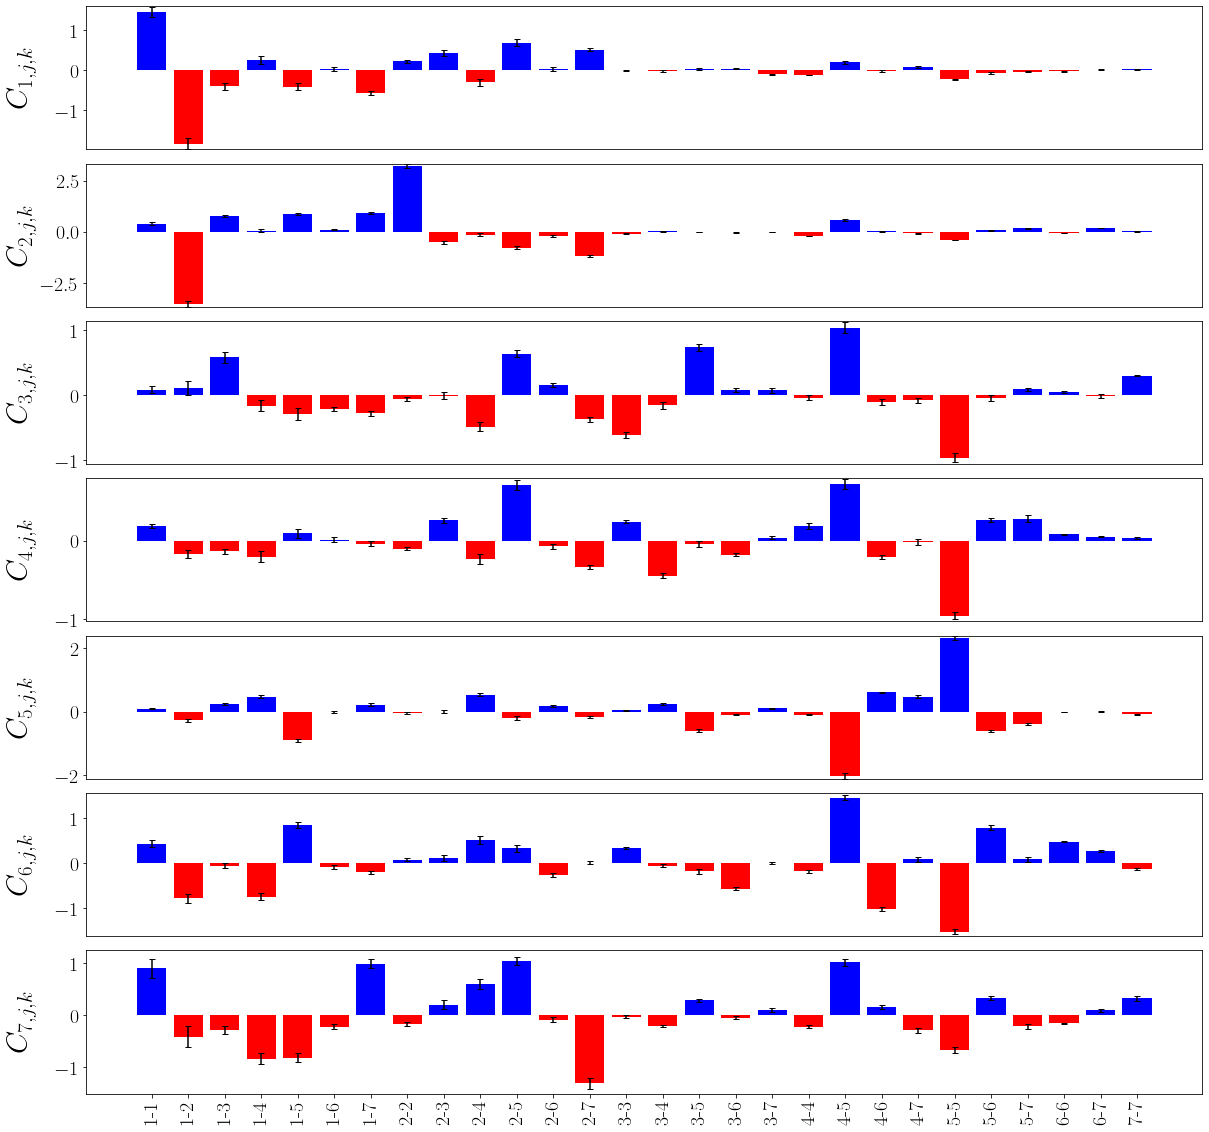

In [25]:
plt.rc('text', usetex=True)
plt.rc('font', **{'family':'Computer Modern','size':20})

fig = plt.figure(figsize=(20, 20))  
subgs = fig.add_gridspec(7, 1, hspace=0.1)  
axs = [fig.add_subplot(subgs[i]) for i in range(N)] 


for i in range(N):
    axs[i].bar(range(len(C_i[i])), C_i[i], yerr=C_i_error[i], capsize=3, color=['blue' if x > 0 else 'red' for x in C_i[i]])
    axs[i].set_ylim(min(C_i[i]) - max(C_i_error[i]), max(C_i[i]) + max(C_i_error[i]))
    axs[i].set_ylabel(rf"$C_{{{i+1},j,k}}$", fontsize=30) 
    axs[i].xaxis.set_ticks([])
axs[6].set_xticks(range(len(C_index_list)))
axs[6].set_xticklabels(C_index_list ,rotation=90)
fig.align_ylabels(axs[:])


# plt.savefig('res/Power Grid Fig - Cijk - Final - Final - Final.pdf' , dpi=300, bbox_inches='tight')
plt.savefig('res/Power Grid Fig - Cijk - Final - Final - Final.jpeg' , dpi=300, bbox_inches='tight')
plt.show()



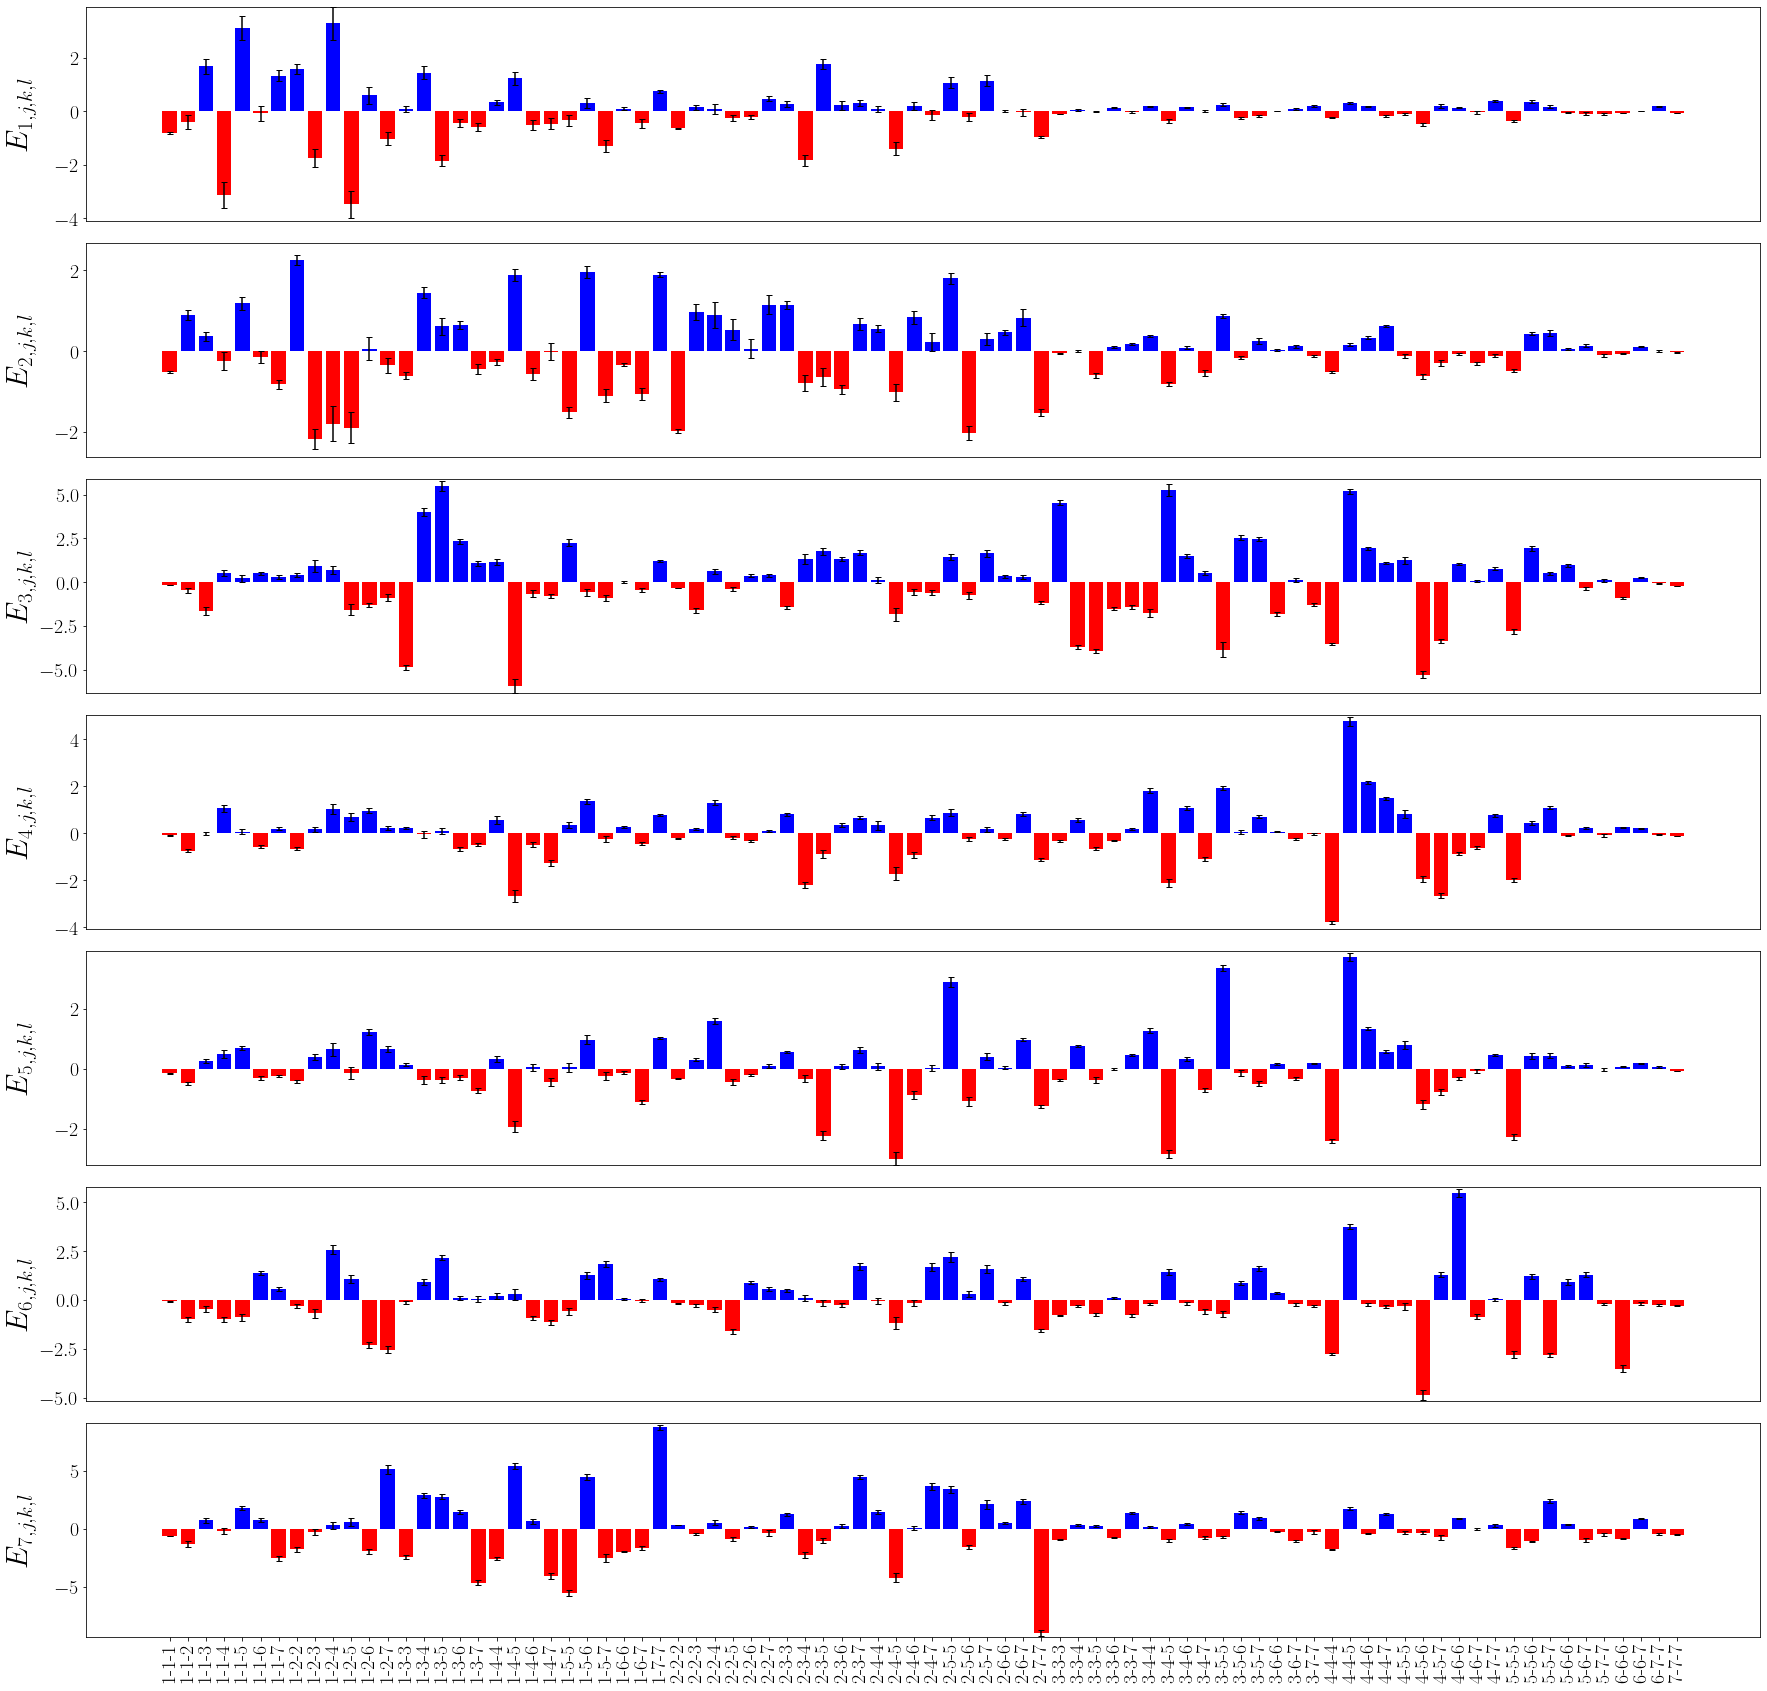

In [26]:
plt.rc('text', usetex=True)
plt.rc('font', **{'family':'Computer Modern','size':20})

fig = plt.figure(figsize=(30, 30))  
subgs = fig.add_gridspec(7, 1, hspace=0.1)  # Create grid spec for 7 subplots
axs = [fig.add_subplot(subgs[i]) for i in range(N)] 



for i in range(N):
    axs[i].bar(range(len(E_i[i])), E_i[i], yerr=E_i_error[i], capsize=3, color=['blue' if x > 0 else 'red' for x in E_i[i]])
    axs[i].set_ylim(min(E_i[i]) - max(E_i_error[i]), max(E_i[i]) + max(E_i_error[i]))
    axs[i].set_ylabel(rf"$E_{{{i+1},j,k,l}}$", fontsize=30) # Customize as needed
    axs[i].xaxis.set_ticks([])
axs[6].set_xticks(range(len(E_index_list)))
axs[6].set_xticklabels(E_index_list, rotation=90)
fig.align_ylabels(axs[:])


# plt.savefig('res/Power Grid Fig - Eijkl - Final - Final - Final.pdf' , dpi=300, bbox_inches='tight')
plt.savefig('res/Power Grid Fig - Eijkl - Final - Final - Final.jpeg' , dpi=300, bbox_inches='tight')
plt.show()
